# Demo 3 Results Visualization

This notebook visualizes the stability boundary results from Demo 3 experiments.

**Two versions:**
- **b0=0**: No Chunked-Prefill (Prefill is atomic)
- **b0=64**: Chunked-Prefill enabled (Default)

**Configuration:**
- Prompt: LogNormal(μ=3.2764, σ=1.5201)
- Output: Geometric(p=0.00560)
- Service time: Random (c=45.5ms, a=0.30ms)
- Three schedulers: Decode-First, Prefill-First, Hybrid

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.gridspec import GridSpec

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.size'] = 11

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## Load Data

In [9]:
def load_demo3_data(b0_version):
    """Load Demo 3 data for specified b0 version"""
    results = {}
    schedulers = [
        ('decode_prioritizing', 'Decode-First'),
        ('prefill_prioritizing', 'Prefill-First'),
        ('hybrid', 'Hybrid')
    ]
    
    for sched_key, sched_name in schedulers:
        if b0_version == 0:
            filename = f'data/Demo3_b0_0_{sched_key}_results.csv'
        else:
            filename = f'data/Demo3_{sched_key}_results.csv'
        
        if os.path.exists(filename):
            df = pd.read_csv(filename)
            results[sched_name] = df
            print(f"  ✓ Loaded: {filename} ({len(df)} points)")
        else:
            print(f"  ✗ Not found: {filename}")
    
    return results


print("Loading b0=0 data:")
data_b0_0 = load_demo3_data(0)

print("\nLoading b0=64 data:")
data_b0_64 = load_demo3_data(64)

Loading b0=0 data:
  ✓ Loaded: data/Demo3_b0_0_decode_prioritizing_results.csv (9 points)
  ✓ Loaded: data/Demo3_b0_0_prefill_prioritizing_results.csv (7 points)
  ✓ Loaded: data/Demo3_b0_0_hybrid_results.csv (7 points)

Loading b0=64 data:
  ✓ Loaded: data/Demo3_decode_prioritizing_results.csv (9 points)
  ✓ Loaded: data/Demo3_prefill_prioritizing_results.csv (7 points)
  ✓ Loaded: data/Demo3_hybrid_results.csv (9 points)


## Helper Functions

In [10]:
def find_lambda_star(df):
    """Find stability boundary from dataframe"""
    stable = df[df['Stable'] == 'Yes']
    unstable = df[df['Stable'] == 'No']
    
    if len(stable) == 0:
        return None, None
    
    if len(unstable) == 0:
        return stable['Lambda'].max(), 0.0
    
    lambda_max_stable = stable['Lambda'].max()
    lambda_min_unstable = unstable['Lambda'].min()
    
    lambda_star = (lambda_max_stable + lambda_min_unstable) / 2
    conf_width = lambda_min_unstable - lambda_max_stable
    
    return lambda_star, conf_width

def create_4panel_figure(df, scheduler_name, lambda_star, conf_width, b0_version):
    """Create 4-panel stability analysis figure"""
    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)
    

    stable = df[df['Stable'] == 'Yes']
    unstable = df[df['Stable'] == 'No']
    

    color_stable = '#2ecc71'
    color_unstable = '#e74c3c'
    
    # Panel 1: Throughput vs Arrival Rate
    ax1 = fig.add_subplot(gs[0, 0])
    
    if len(stable) > 0:
        ax1.plot(stable['Lambda'], stable['QPS'], 'o-', 
                color=color_stable, linewidth=2, markersize=8, label='Stable', zorder=3)
    if len(unstable) > 0:
        ax1.plot(unstable['Lambda'], unstable['QPS'], 'x--', 
                color=color_unstable, linewidth=2, markersize=10, label='Unstable', zorder=3)
    
    # Ideal line
    lambda_range = [df['Lambda'].min(), df['Lambda'].max()]
    ax1.plot(lambda_range, lambda_range, ':', color='gray', alpha=0.5, label='Ideal', zorder=1)
    
    # Lambda star line
    if lambda_star:
        ax1.axvline(lambda_star, color='orange', linestyle='--', linewidth=2, 
                   label=f'λ*={lambda_star:.3f}', zorder=2)
    
    ax1.set_xlabel('λ (queries/s)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Throughput (qps)', fontsize=12, fontweight='bold')
    ax1.set_title('Throughput vs Arrival Rate', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Panel 2: Metric Growth Rate
    ax2 = fig.add_subplot(gs[0, 1])
    
    if len(df) > 0:
        # Calculate relative increase from baseline
        baseline_idx = 0
        ttft_baseline = df.iloc[baseline_idx]['TTFT_Avg']
        tbt_baseline = df.iloc[baseline_idx]['TBT_Avg']
        rts_baseline = df.iloc[baseline_idx]['RTS_Avg']
        
        ttft_increase = (df['TTFT_Avg'] - ttft_baseline) / ttft_baseline
        tbt_increase = (df['TBT_Avg'] - tbt_baseline) / tbt_baseline
        rts_increase = (df['RTS_Avg'] - rts_baseline) / rts_baseline
        
        ax2.plot(df['Lambda'], ttft_increase, 'o-', label='TTFT', linewidth=2, markersize=6)
        ax2.plot(df['Lambda'], tbt_increase, 's-', label='TBT', linewidth=2, markersize=6)
        ax2.plot(df['Lambda'], rts_increase, '^-', label='RTS', linewidth=2, markersize=6)
        
        # 10% threshold line
        ax2.axhline(0.1, color='orange', linestyle='--', linewidth=1.5, 
                   label='Threshold (10%)', alpha=0.7)
    
    ax2.set_xlabel('λ (queries/s)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Relative Increase', fontsize=12, fontweight='bold')
    ax2.set_title('Metric Growth Rate', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # Panel 3: Congestion Type Distribution
    ax3 = fig.add_subplot(gs[1, 0])
    
    congestion_types = {'None': 0, 'TTFT': 0, 'TBT': 0, 'RTS': 0}
    
    for _, row in df.iterrows():
        if row['Stable'] == 'Yes':
            congestion_types['None'] += 1
        else:
            ttft_rel = (row['TTFT_Avg'] - ttft_baseline) / ttft_baseline
            tbt_rel = (row['TBT_Avg'] - tbt_baseline) / tbt_baseline
            
            if ttft_rel > tbt_rel and ttft_rel > 0.15:
                congestion_types['TTFT'] += 1
            elif tbt_rel > ttft_rel and tbt_rel > 0.15:
                congestion_types['TBT'] += 1
            else:
                congestion_types['RTS'] += 1
    
    congestion_types = {k: v for k, v in congestion_types.items() if v > 0}
    
    colors_cong = {
        'None': color_stable,
        'TTFT': '#3498db',
        'TBT': '#f39c12',
        'RTS': '#9b59b6'
    }
    
    bars = ax3.bar(congestion_types.keys(), congestion_types.values(),
                   color=[colors_cong[k] for k in congestion_types.keys()],
                   edgecolor='black', linewidth=1.5)
    
    ax3.set_xlabel('Congestion Type', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax3.set_title('Congestion Type Distribution', fontsize=13, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Panel 4: Tail Latency
    ax4 = fig.add_subplot(gs[1, 1])
    
    if len(stable) > 0:
        ax4.plot(stable['Lambda'], stable['RTS_P95'], 'o-', 
                color=color_stable, linewidth=2, markersize=8, label='Stable', zorder=3)
    if len(unstable) > 0:
        ax4.plot(unstable['Lambda'], unstable['RTS_P95'], 'x--', 
                color=color_unstable, linewidth=2, markersize=10, label='Unstable', zorder=3)
    
    ax4.set_xlabel('λ (queries/s)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('P95 RTS (s)', fontsize=12, fontweight='bold')
    ax4.set_title('Tail Latency', fontsize=13, fontweight='bold')
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3)
    
    b0_label = "b0=0 (No Chunked-Prefill)" if b0_version == 0 else "b0=64 (Chunked-Prefill)"
    fig.suptitle(f'Stability Boundary Analysis: Demo3_{scheduler_name} ({b0_label})', 
                fontsize=16, fontweight='bold', y=0.995)
    
    return fig

print("✓ Helper functions defined")

✓ Helper functions defined


## Generate Figures for b0=0 Version

In [11]:
os.makedirs('figs', exist_ok=True)

if data_b0_0:
    print("\n" + "="*80)
    print("Generating figures for b0=0 (No Chunked-Prefill)")
    print("="*80)
    
    for scheduler_name, df in data_b0_0.items():
        print(f"\n{scheduler_name}:")
        lambda_star, conf_width = find_lambda_star(df)
        
        if lambda_star:
            if conf_width > 0:
                print(f"  λ* = {lambda_star:.4f} ± {conf_width/2:.4f}")
            else:
                print(f"  λ* > {lambda_star:.4f}")
        else:
            print(f"  No stable region found")
        

        fig = create_4panel_figure(df, scheduler_name.replace(' ', '_').replace('-', '_').lower(), 
                                   lambda_star, conf_width, b0_version=0)
        
        filename = f"figs/Demo3_b0_0_{scheduler_name.replace(' ', '_').replace('-', '_').lower()}_stability_boundary.png"
        fig.savefig(filename, dpi=150, bbox_inches='tight')
        print(f"  ✓ Saved: {filename}")
        plt.close(fig)
else:
    print("\n⚠️ No b0=0 data found")


Generating figures for b0=0 (No Chunked-Prefill)

Decode-First:
  No stable region found
  ✓ Saved: figs/Demo3_b0_0_decode_first_stability_boundary.png

Prefill-First:
  λ* = 1.2500 ± 0.2500
  ✓ Saved: figs/Demo3_b0_0_prefill_first_stability_boundary.png

Hybrid:
  λ* = 2.7500 ± 0.2500
  ✓ Saved: figs/Demo3_b0_0_hybrid_stability_boundary.png


## Generate Figures for b0=64 Version

In [12]:
if data_b0_64:
    print("\n" + "="*80)
    print("Generating figures for b0=64 (Chunked-Prefill Enabled)")
    print("="*80)
    
    for scheduler_name, df in data_b0_64.items():
        print(f"\n{scheduler_name}:")
        lambda_star, conf_width = find_lambda_star(df)
        
        if lambda_star:
            if conf_width > 0:
                print(f"  λ* = {lambda_star:.4f} ± {conf_width/2:.4f}")
            else:
                print(f"  λ* > {lambda_star:.4f}")
        else:
            print(f"  No stable region found")
        

        fig = create_4panel_figure(df, scheduler_name.replace(' ', '_').replace('-', '_').lower(), 
                                   lambda_star, conf_width, b0_version=64)
        

        filename = f"figs/Demo3_{scheduler_name.replace(' ', '_').replace('-', '_').lower()}_stability_boundary.png"
        fig.savefig(filename, dpi=150, bbox_inches='tight')
        print(f"  ✓ Saved: {filename}")
        plt.close(fig)
else:
    print("\n⚠️ No b0=64 data found")


Generating figures for b0=64 (Chunked-Prefill Enabled)

Decode-First:
  No stable region found
  ✓ Saved: figs/Demo3_decode_first_stability_boundary.png

Prefill-First:
  λ* = 2.2500 ± 0.2500
  ✓ Saved: figs/Demo3_prefill_first_stability_boundary.png

Hybrid:
  λ* = 8.2500 ± 0.2500
  ✓ Saved: figs/Demo3_hybrid_stability_boundary.png


## Comparison Figure: b0=0 vs b0=64

In [13]:
if data_b0_0 and data_b0_64:
    print("\n" + "="*80)
    print("Generating comparison figure")
    print("="*80)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Panel 1: Throughput Comparison
    ax1 = axes[0]
    
    schedulers_list = ['Decode-First', 'Prefill-First', 'Hybrid']
    colors = {'Decode-First': '#e74c3c', 'Prefill-First': '#3498db', 'Hybrid': '#2ecc71'}
    markers_b0_0 = {'Decode-First': 'o', 'Prefill-First': 's', 'Hybrid': '^'}
    markers_b0_64 = {'Decode-First': 'x', 'Prefill-First': '+', 'Hybrid': 'd'}
    
    for sched in schedulers_list:
        if sched in data_b0_0:
            df = data_b0_0[sched]
            stable = df[df['Stable'] == 'Yes']
            if len(stable) > 0:
                ax1.plot(stable['Lambda'], stable['QPS'], 
                        marker=markers_b0_0[sched], linestyle='-',
                        color=colors[sched], linewidth=2, markersize=8,
                        label=f'{sched} (b0=0)', alpha=0.7)
        
        if sched in data_b0_64:
            df = data_b0_64[sched]
            stable = df[df['Stable'] == 'Yes']
            if len(stable) > 0:
                ax1.plot(stable['Lambda'], stable['QPS'], 
                        marker=markers_b0_64[sched], linestyle='--',
                        color=colors[sched], linewidth=2, markersize=8,
                        label=f'{sched} (b0=64)', alpha=0.7)
    
    # Ideal line
    all_lambdas = []
    for data_dict in [data_b0_0, data_b0_64]:
        for df in data_dict.values():
            all_lambdas.extend(df['Lambda'].tolist())
    lambda_range = [min(all_lambdas), max(all_lambdas)]
    ax1.plot(lambda_range, lambda_range, ':', color='gray', alpha=0.5, label='Ideal')
    
    ax1.set_xlabel('λ (queries/s)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Throughput (qps)', fontsize=12, fontweight='bold')
    ax1.set_title('Throughput Comparison', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=9, loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Panel 2: Lambda Star Comparison
    ax2 = axes[1]
    
    lambda_stars_b0_0 = []
    lambda_stars_b0_64 = []
    conf_widths_b0_0 = []
    conf_widths_b0_64 = []
    labels = []
    
    for sched in schedulers_list:
        labels.append(sched)
        
        if sched in data_b0_0:
            ls, cw = find_lambda_star(data_b0_0[sched])
            lambda_stars_b0_0.append(ls if ls else 0)
            conf_widths_b0_0.append(cw/2 if cw else 0)
        else:
            lambda_stars_b0_0.append(0)
            conf_widths_b0_0.append(0)
        
        if sched in data_b0_64:
            ls, cw = find_lambda_star(data_b0_64[sched])
            lambda_stars_b0_64.append(ls if ls else 0)
            conf_widths_b0_64.append(cw/2 if cw else 0)
        else:
            lambda_stars_b0_64.append(0)
            conf_widths_b0_64.append(0)
    
    x = np.arange(len(labels))
    width = 0.35
    
    bars1 = ax2.bar(x - width/2, lambda_stars_b0_0, width, 
                    yerr=conf_widths_b0_0,
                    color=[colors[l] for l in labels],
                    alpha=0.7, label='b0=0',
                    capsize=5, edgecolor='black', linewidth=1.5)
    
    bars2 = ax2.bar(x + width/2, lambda_stars_b0_64, width,
                    yerr=conf_widths_b0_64,
                    color=[colors[l] for l in labels],
                    alpha=0.4, label='b0=64',
                    capsize=5, edgecolor='black', linewidth=1.5, hatch='//')
    
    ax2.set_xlabel('Scheduler', fontsize=12, fontweight='bold')
    ax2.set_ylabel('λ* (queries/s)', fontsize=12, fontweight='bold')
    ax2.set_title('Stability Boundary Comparison', fontsize=13, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    #def add_labels(bars, values, conf_widths):
     #   for bar, val, conf in zip(bars, values, conf_widths):
      #      if val > 0:
       #         height = bar.get_height()
        #        label_text = f'{val:.3f}\n±{conf:.3f}' if conf > 0 else f'{val:.3f}'
         #       ax2.text(bar.get_x() + bar.get_width()/2., height,
          #              label_text,
           #             ha='center', va='bottom', fontsize=9, fontweight='bold')
    def add_labels(bars, values, conf_widths):
        for bar, val, conf in zip(bars, values, conf_widths):
            if val > 0:
                height = bar.get_height()
                label_text = f'{val:.3f}\n±{conf:.3f}' if conf > 0 else f'{val:.3f}'

                y = height + conf + 0.15   # ✅ 往上抬，避开CI cap

                ax2.text(bar.get_x() + bar.get_width()/2., y,
                        label_text,
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

    
    add_labels(bars1, lambda_stars_b0_0, conf_widths_b0_0)
    add_labels(bars2, lambda_stars_b0_64, conf_widths_b0_64)
    
    fig.suptitle('Demo 3: Scheduler Comparison (b0=0 vs b0=64)', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    filename = 'figs/Demo3_comparison.png'
    fig.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"\n✓ Saved: {filename}")
    plt.close(fig)
else:
    print("\n⚠️ Need both b0=0 and b0=64 data for comparison")


Generating comparison figure

✓ Saved: figs/Demo3_comparison.png


## Display All Figures


Generated Figures

figs/Demo3_b0_0_decode_first_stability_boundary.png:


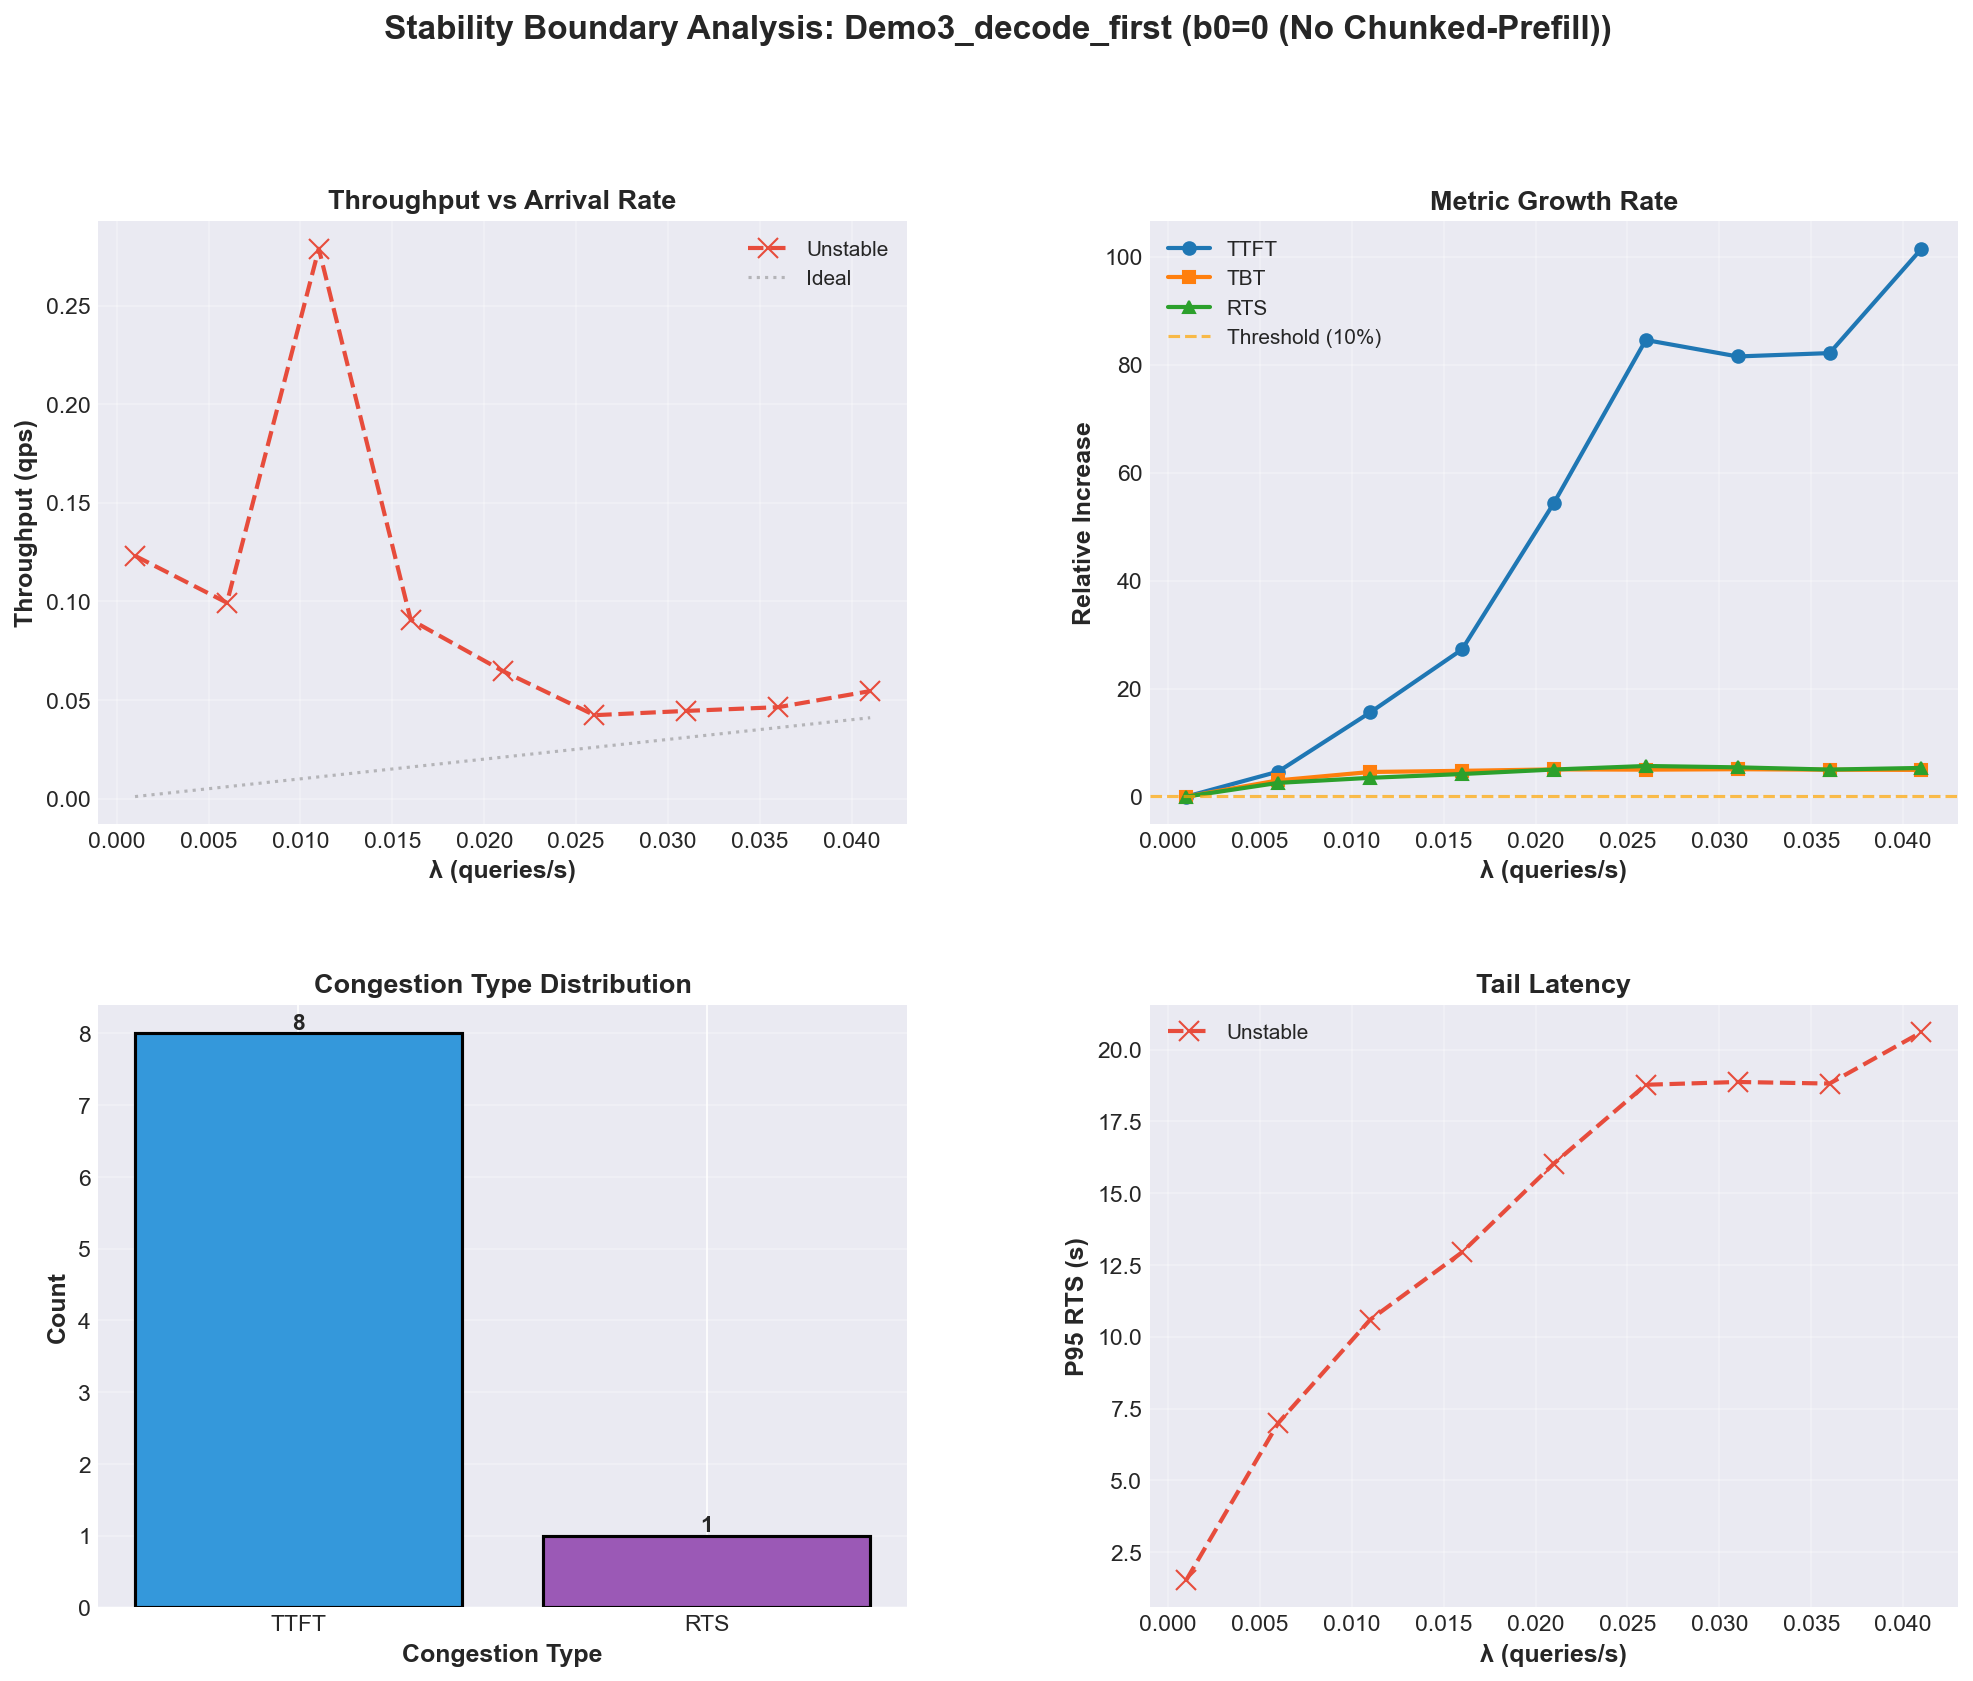


figs/Demo3_b0_0_hybrid_stability_boundary.png:


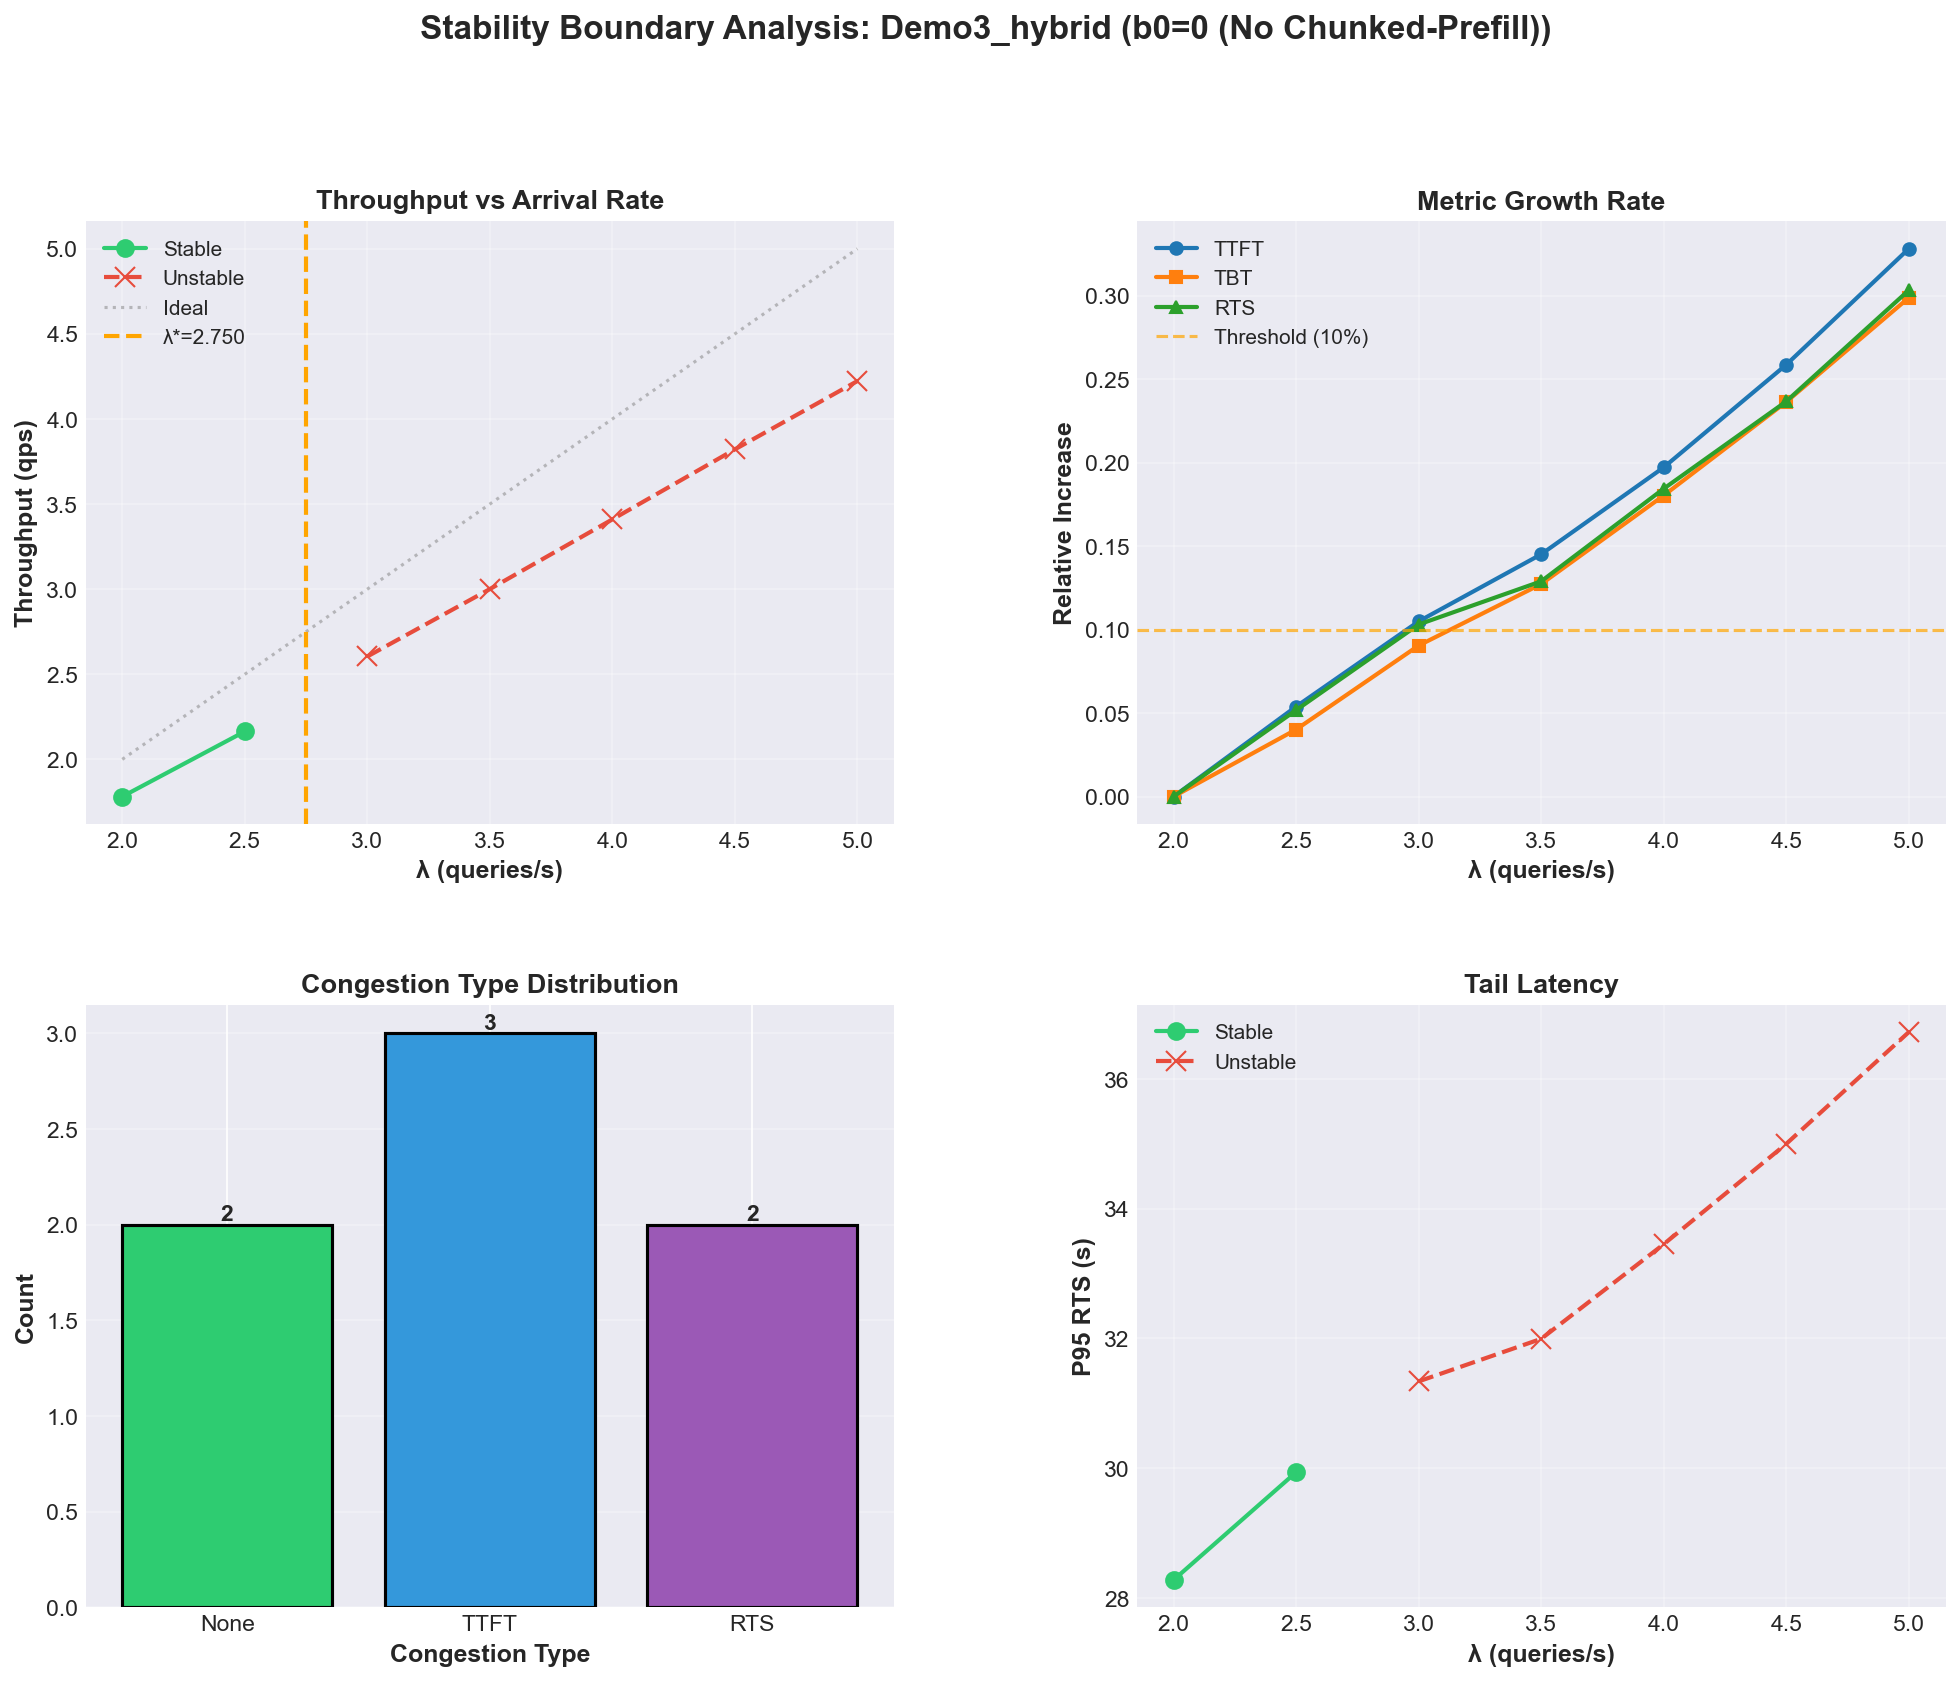


figs/Demo3_b0_0_prefill_first_stability_boundary.png:


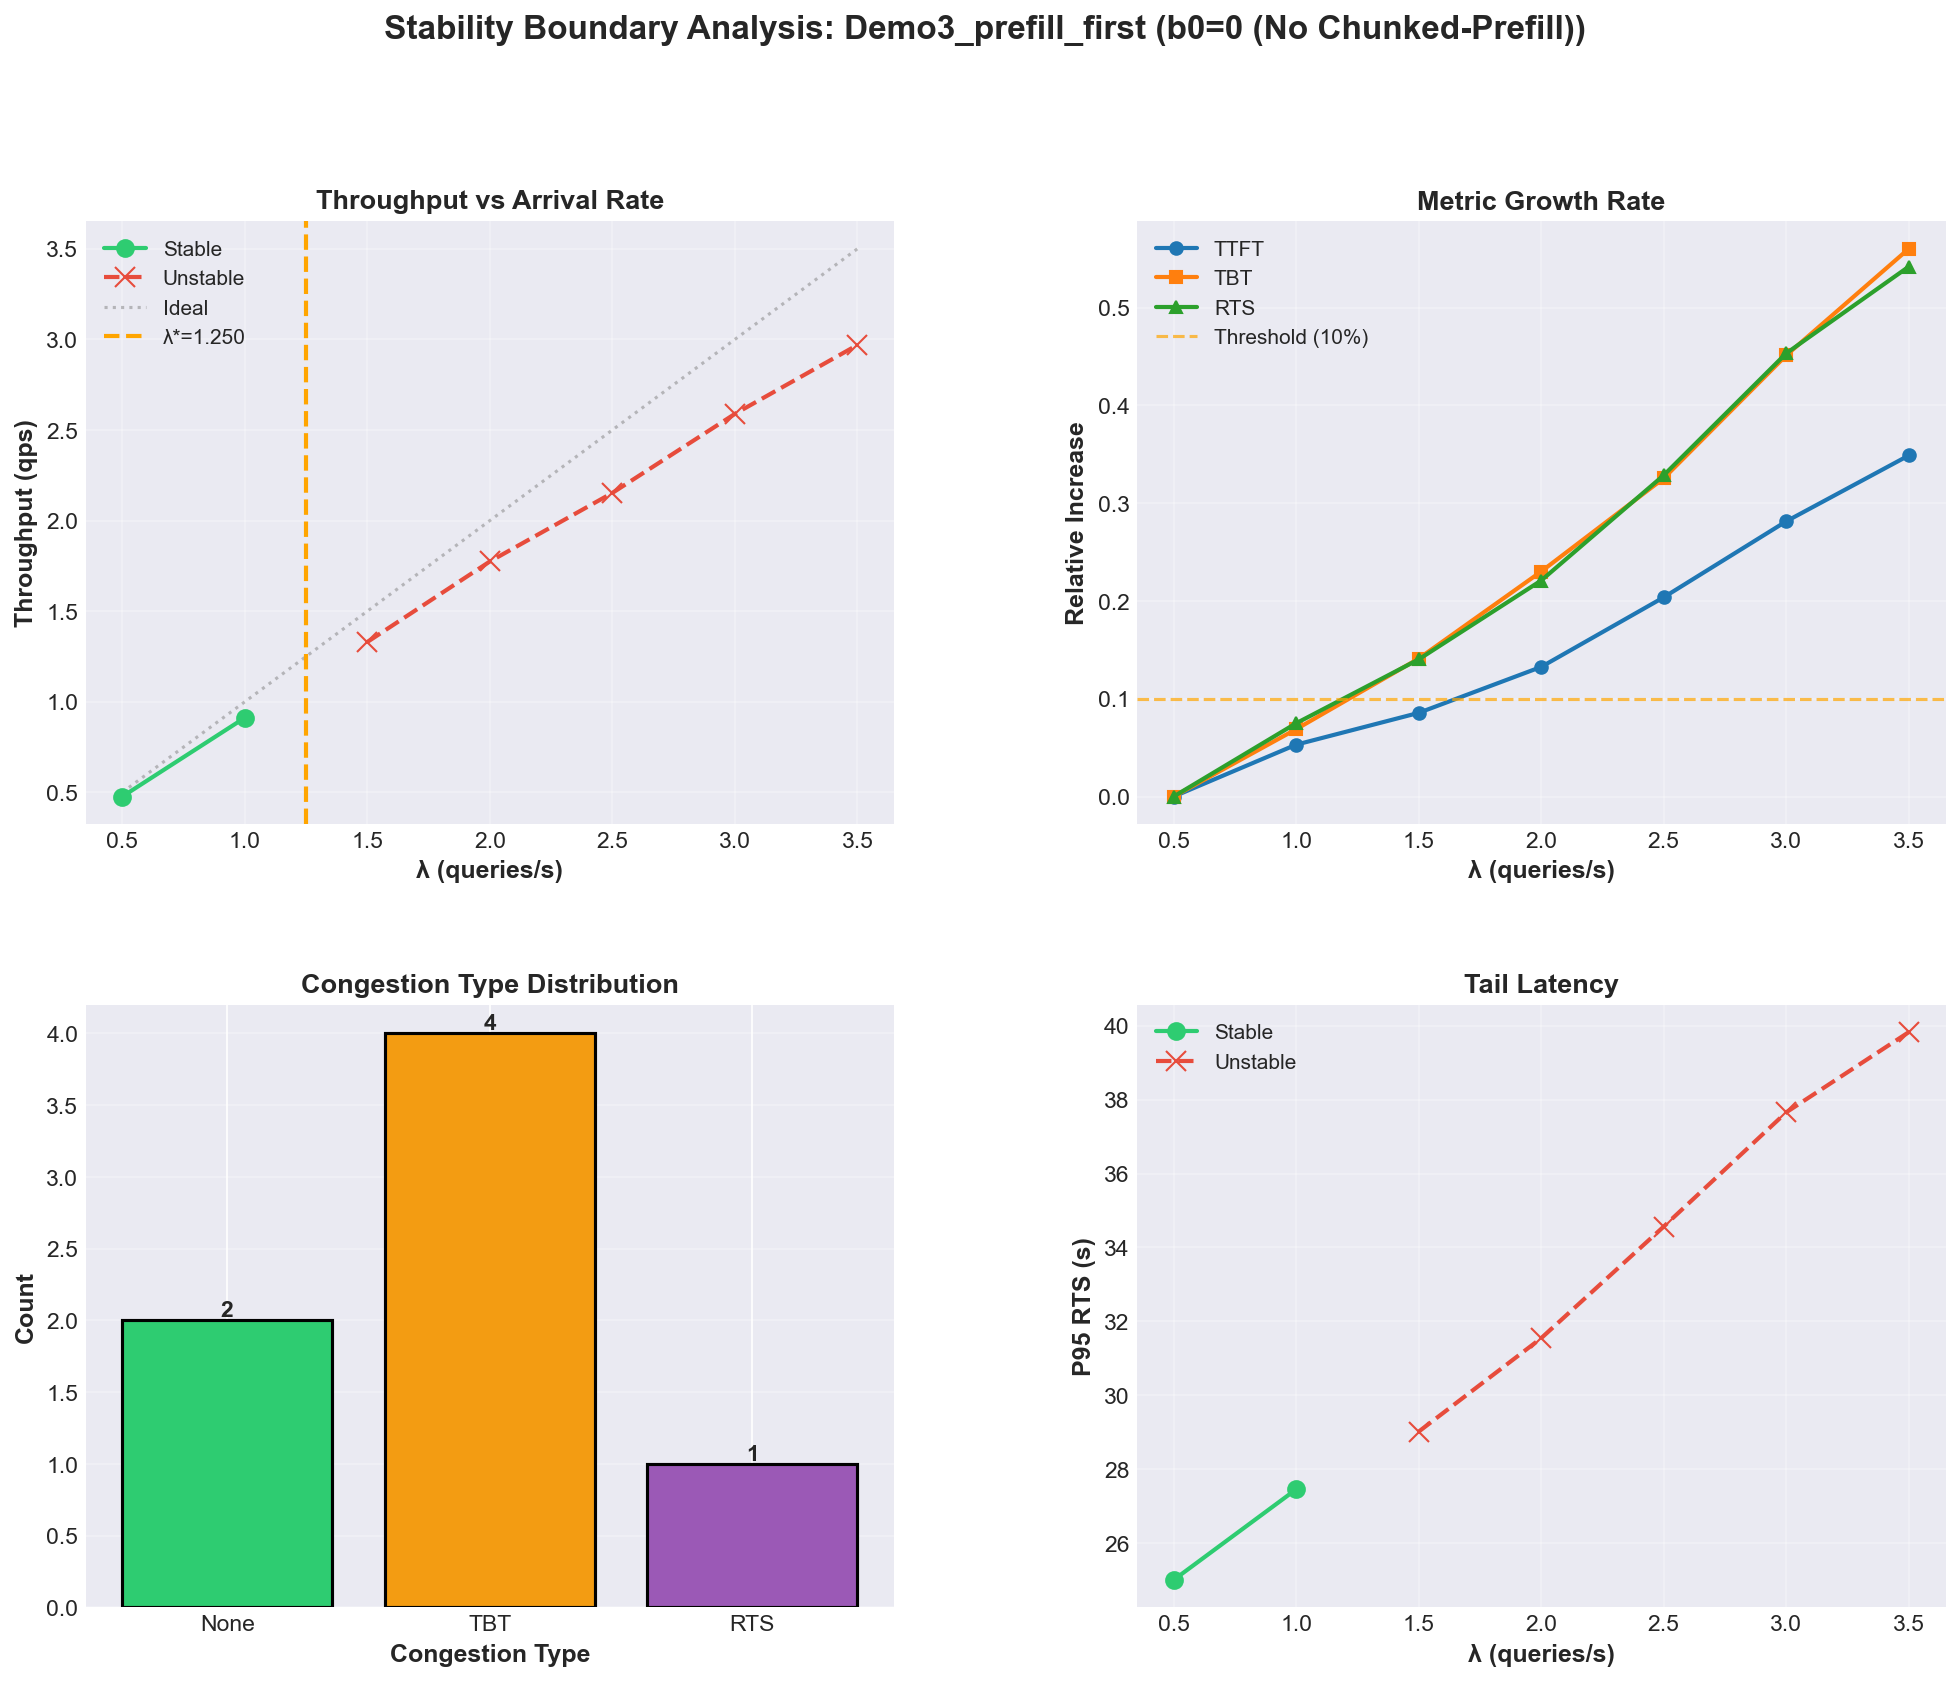


figs/Demo3_comparison.png:


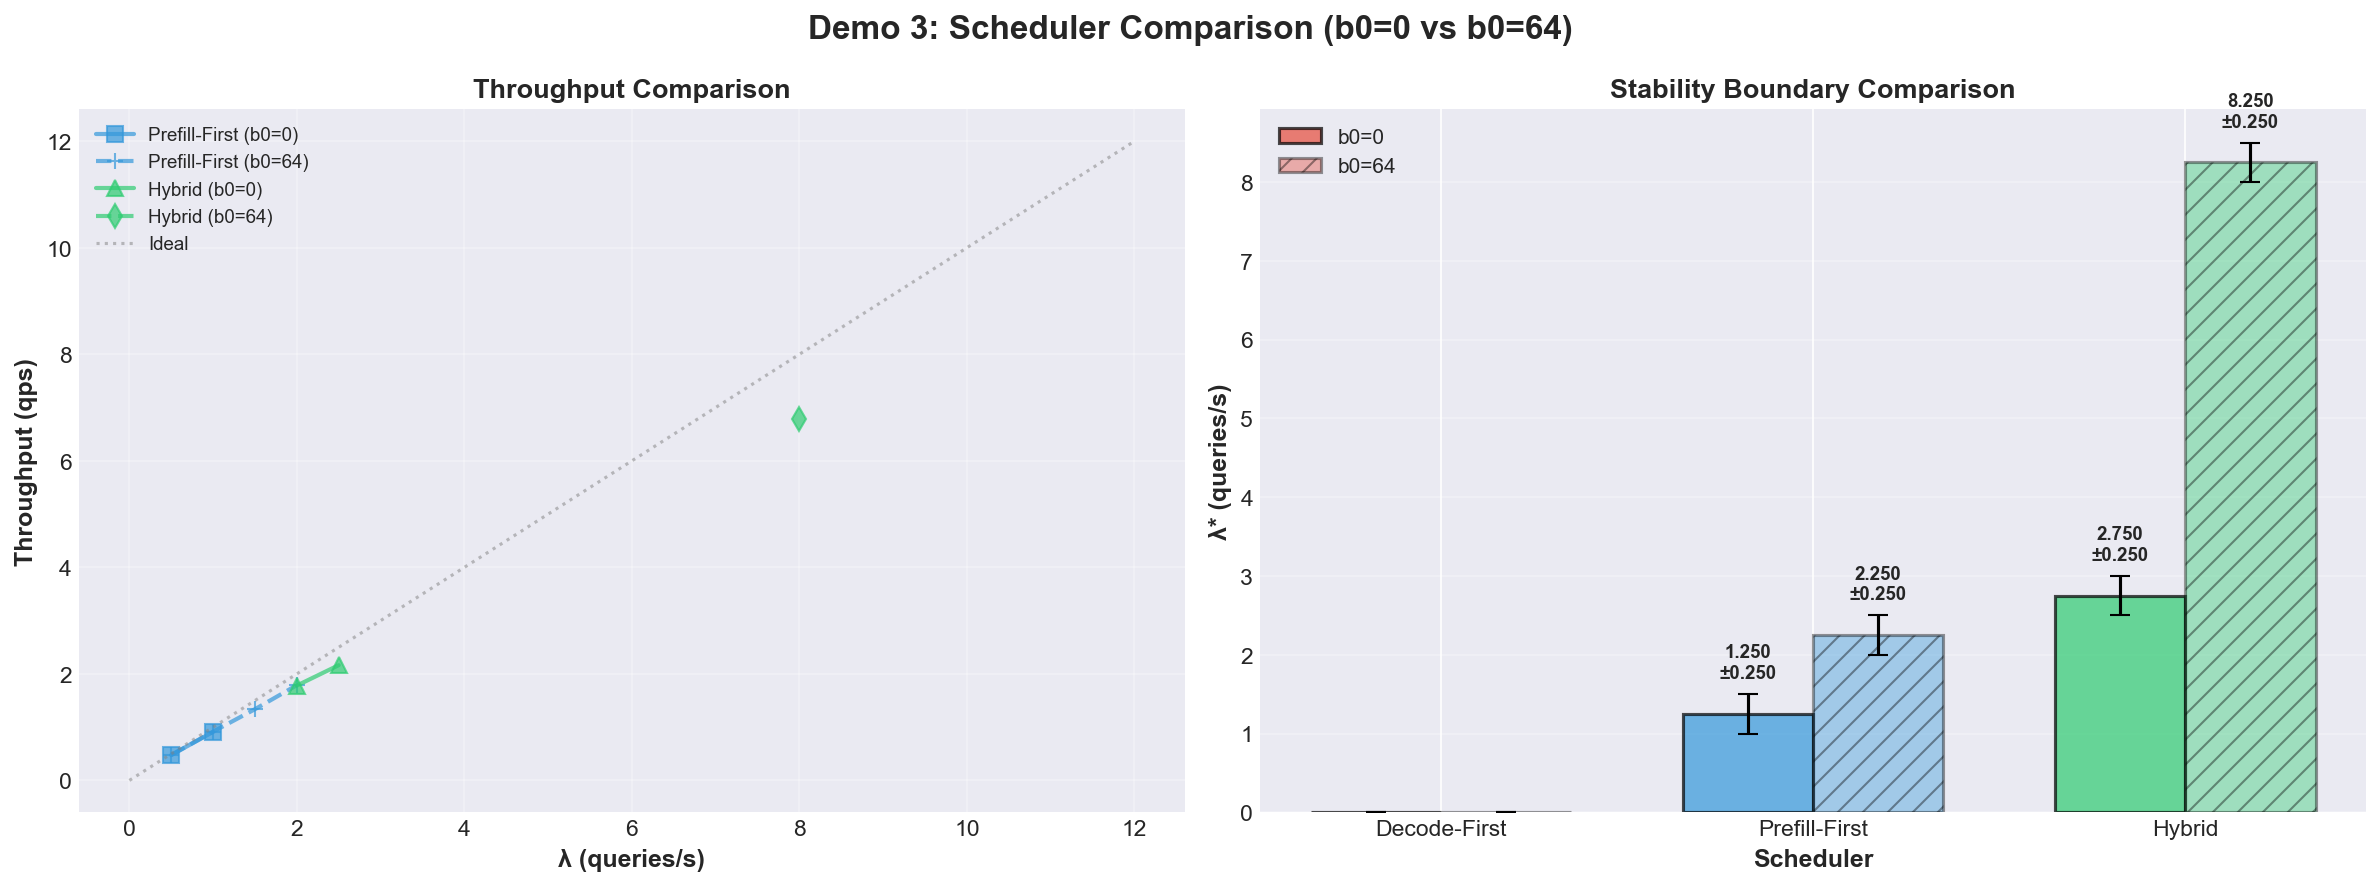


figs/Demo3_decode_first_stability_boundary.png:


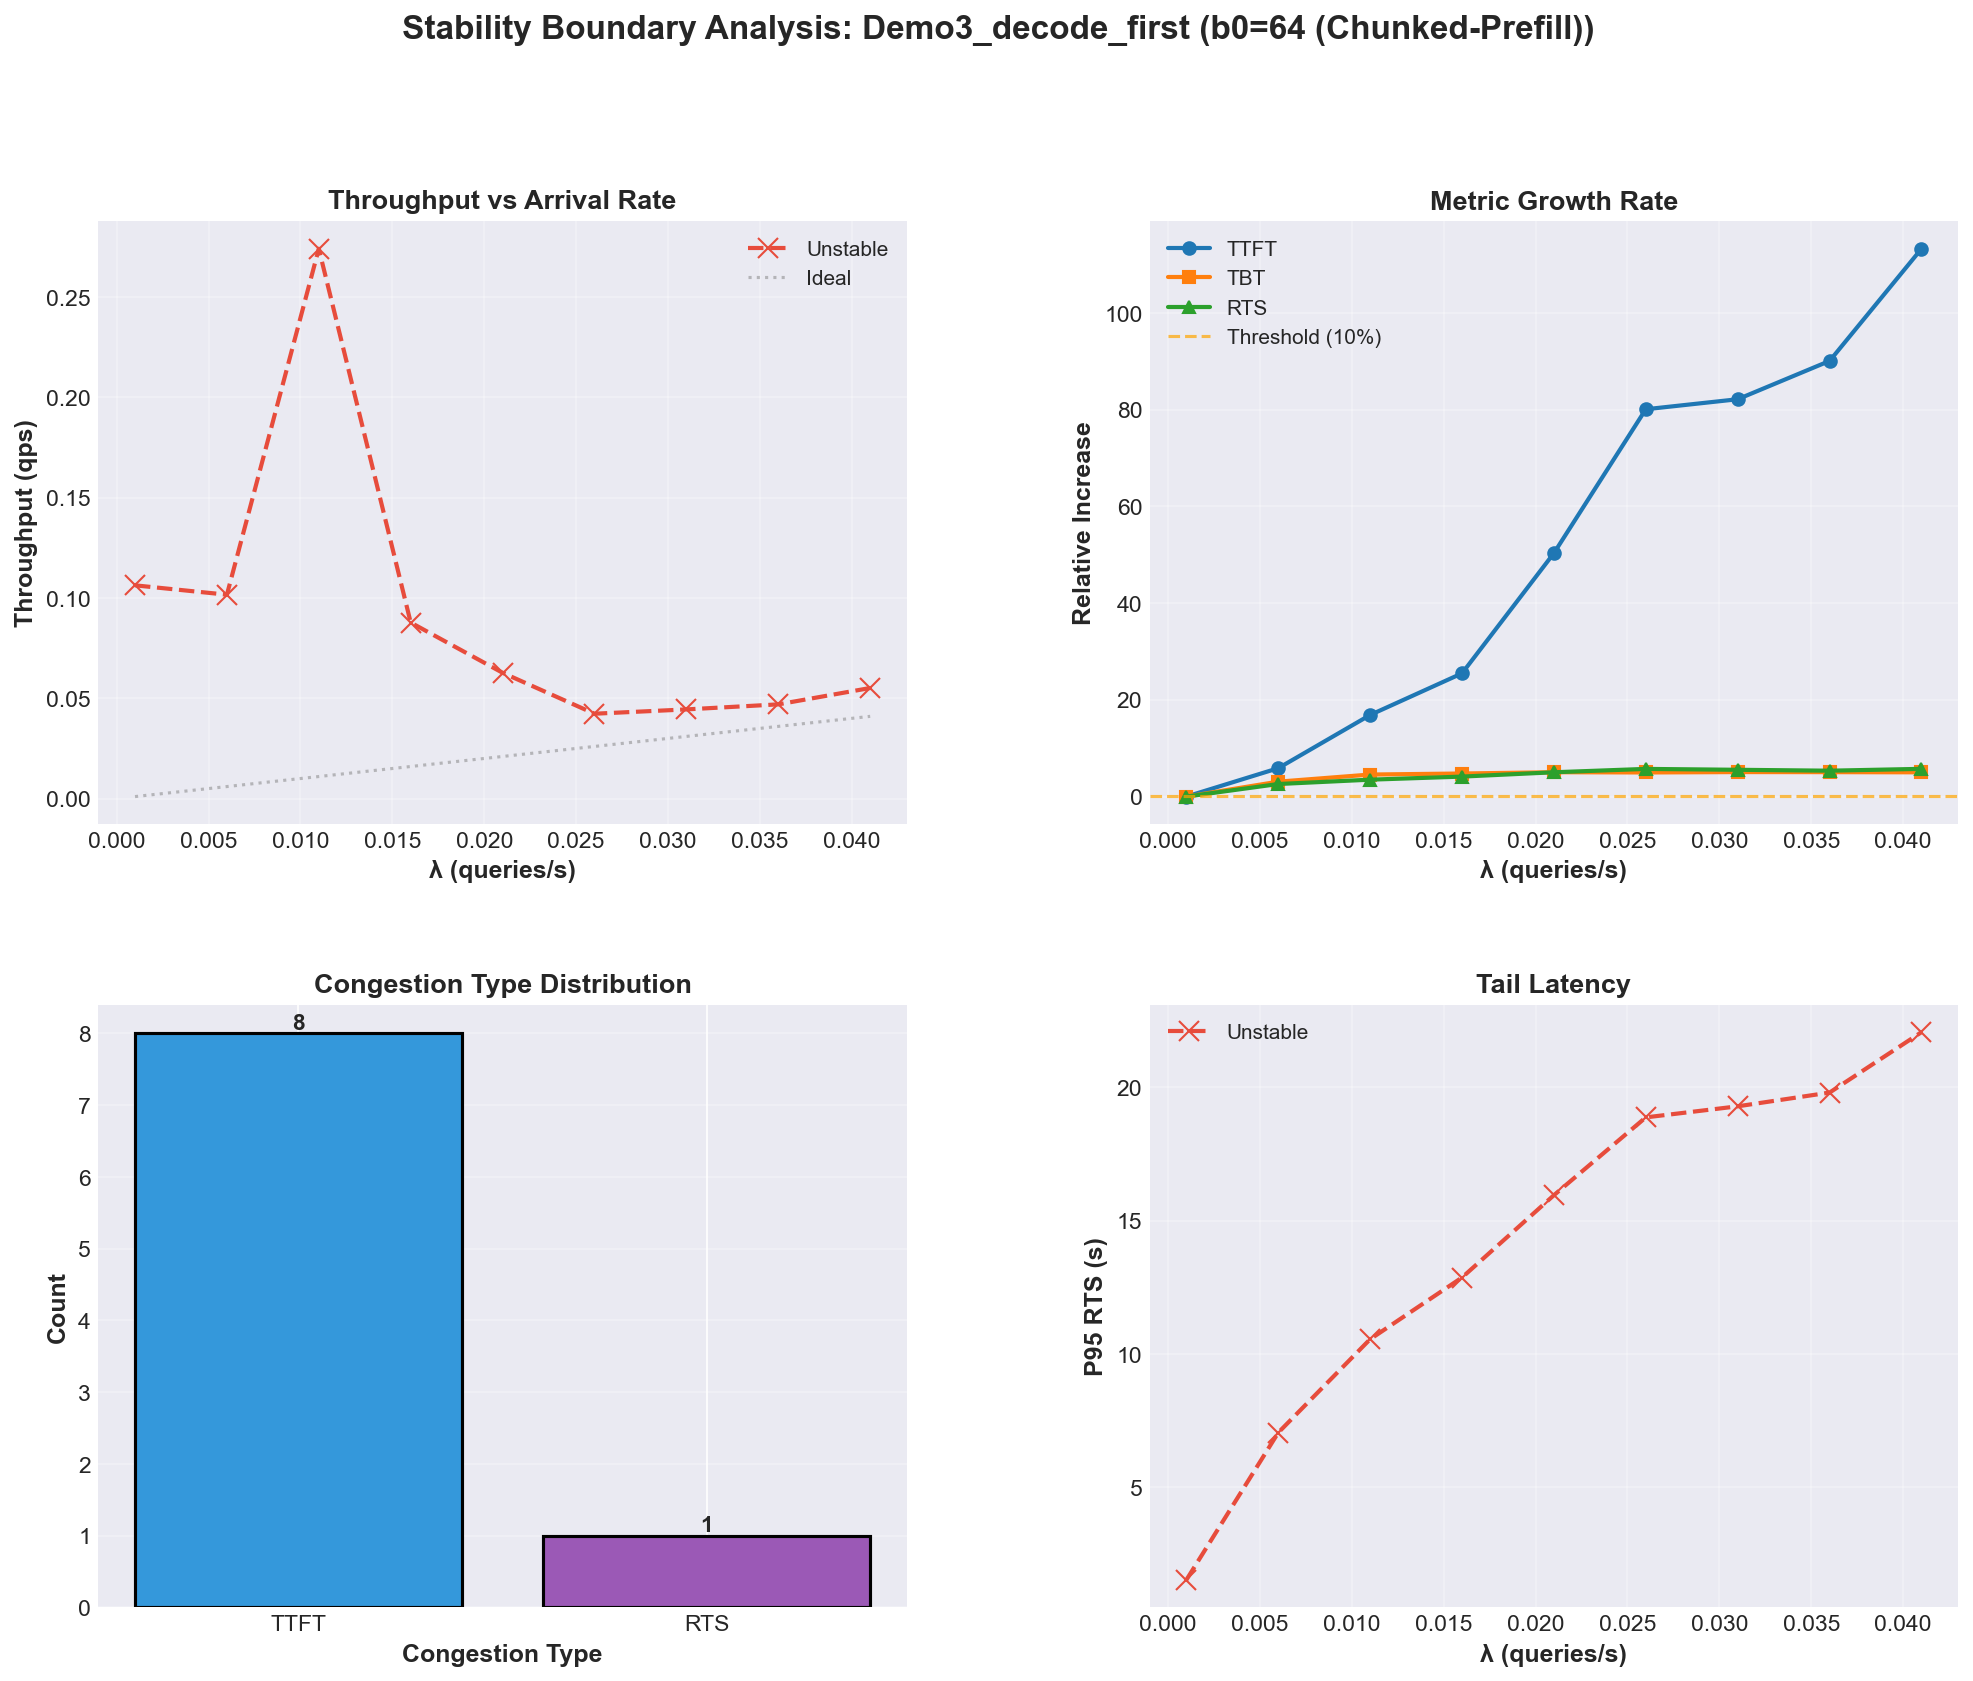


figs/Demo3_hybrid_stability_boundary.png:


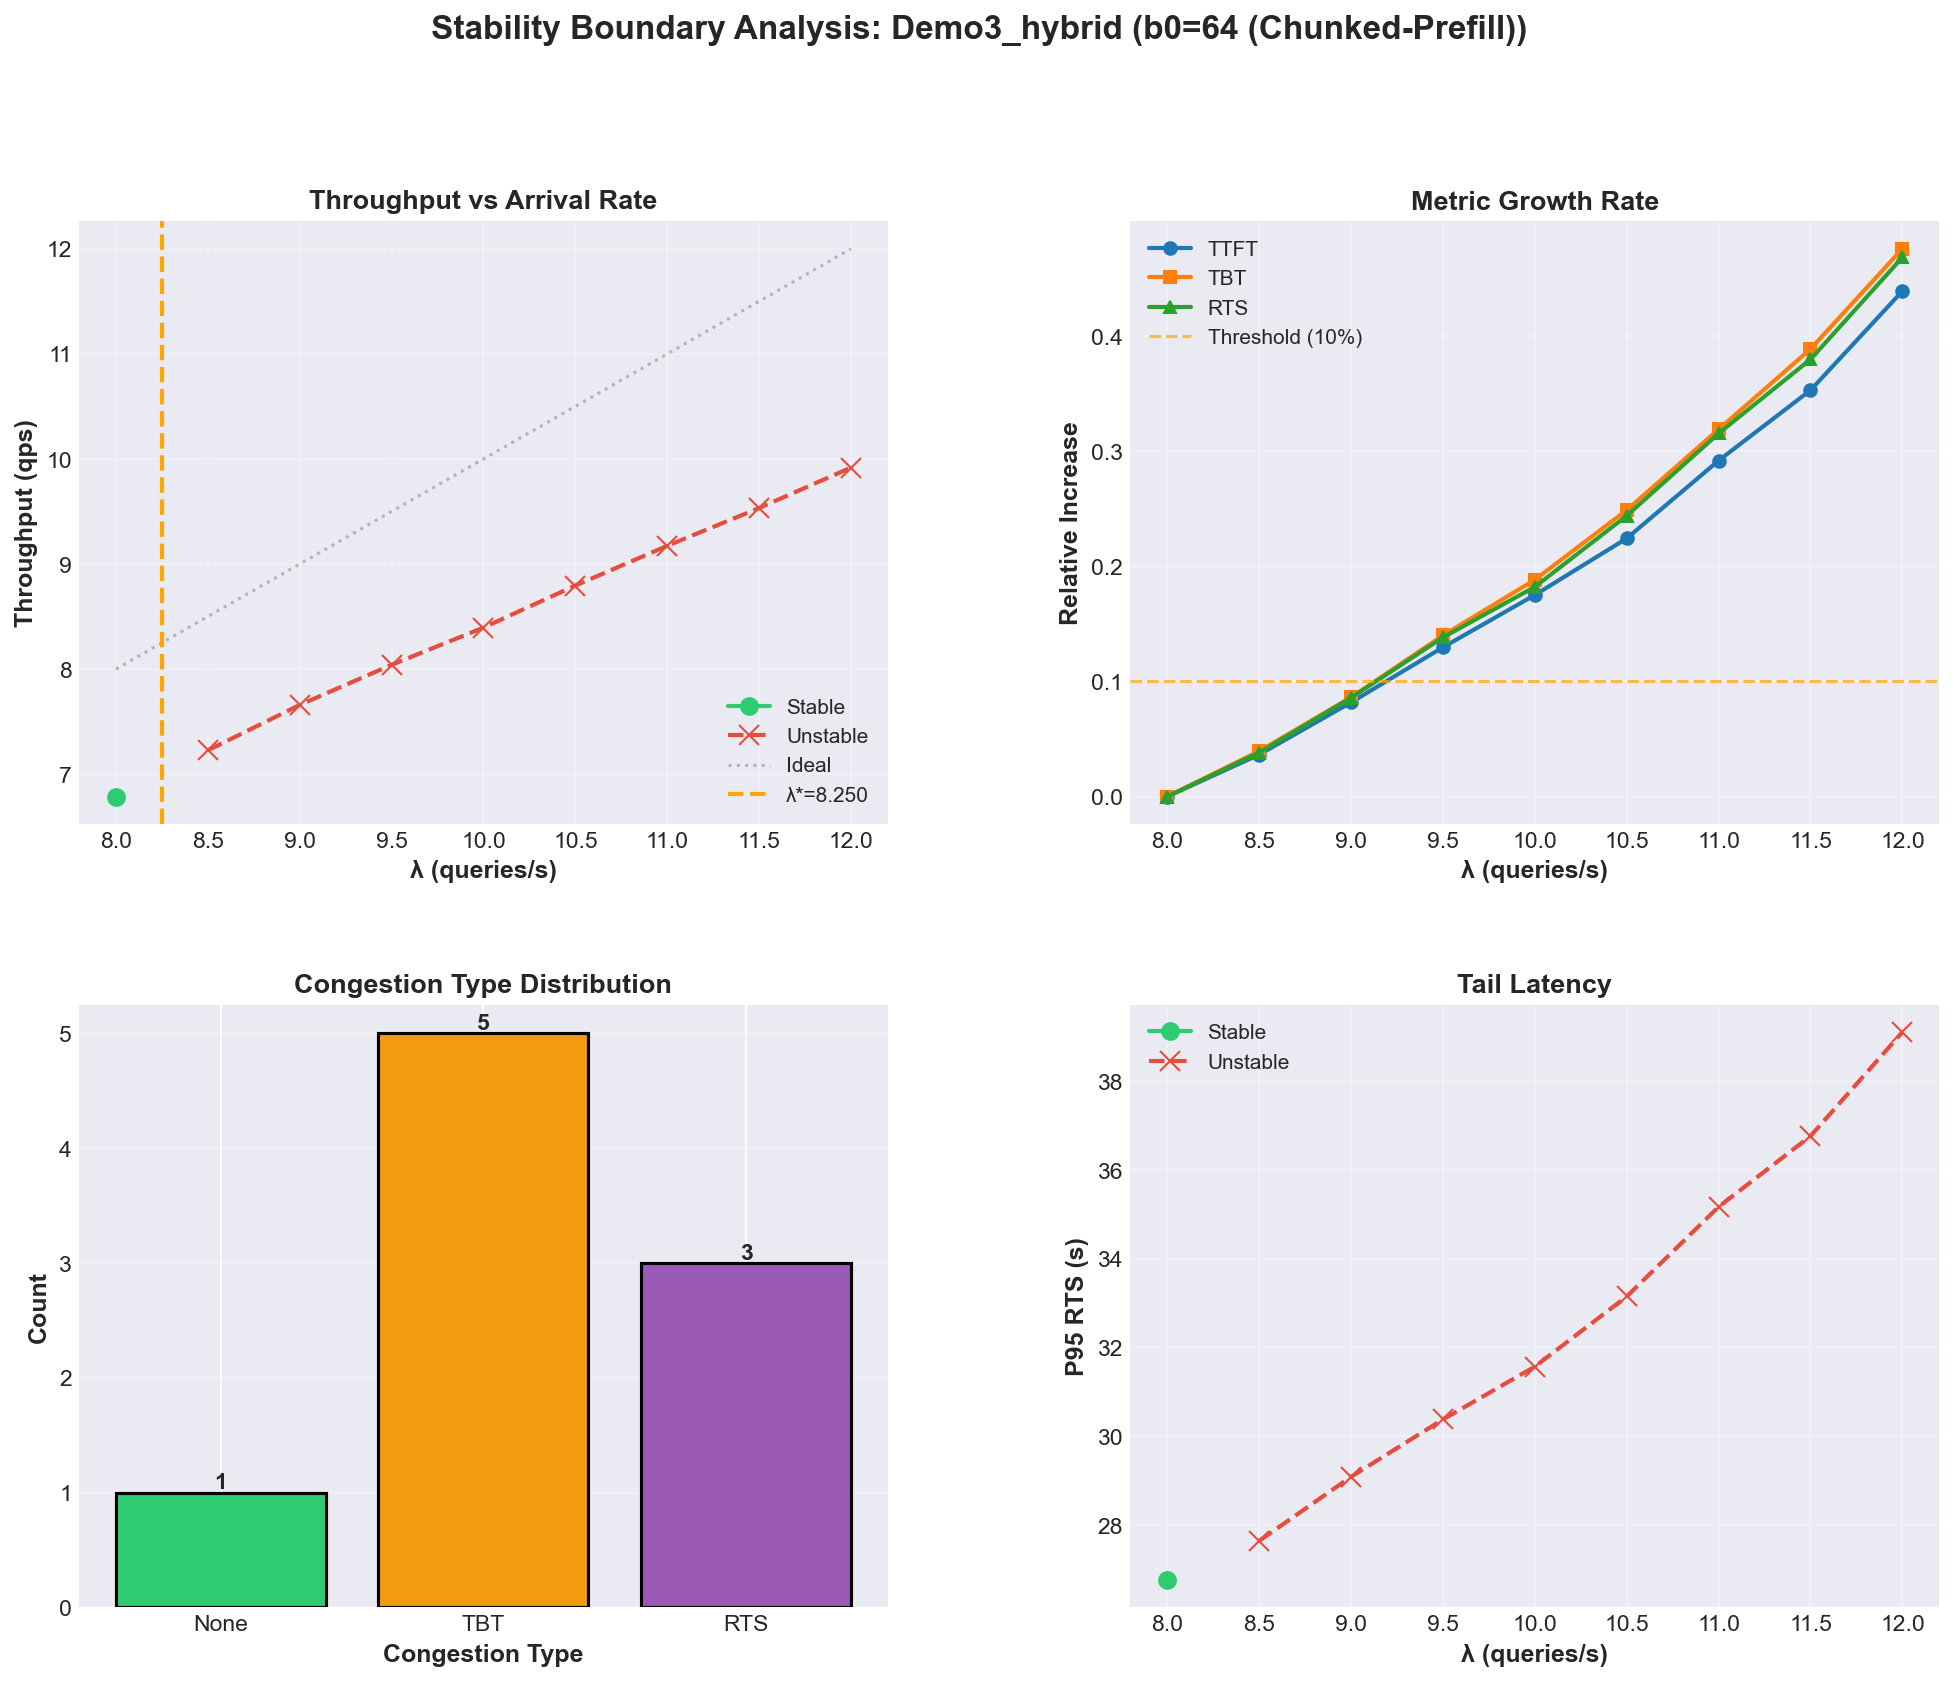


figs/Demo3_prefill_first_stability_boundary.png:


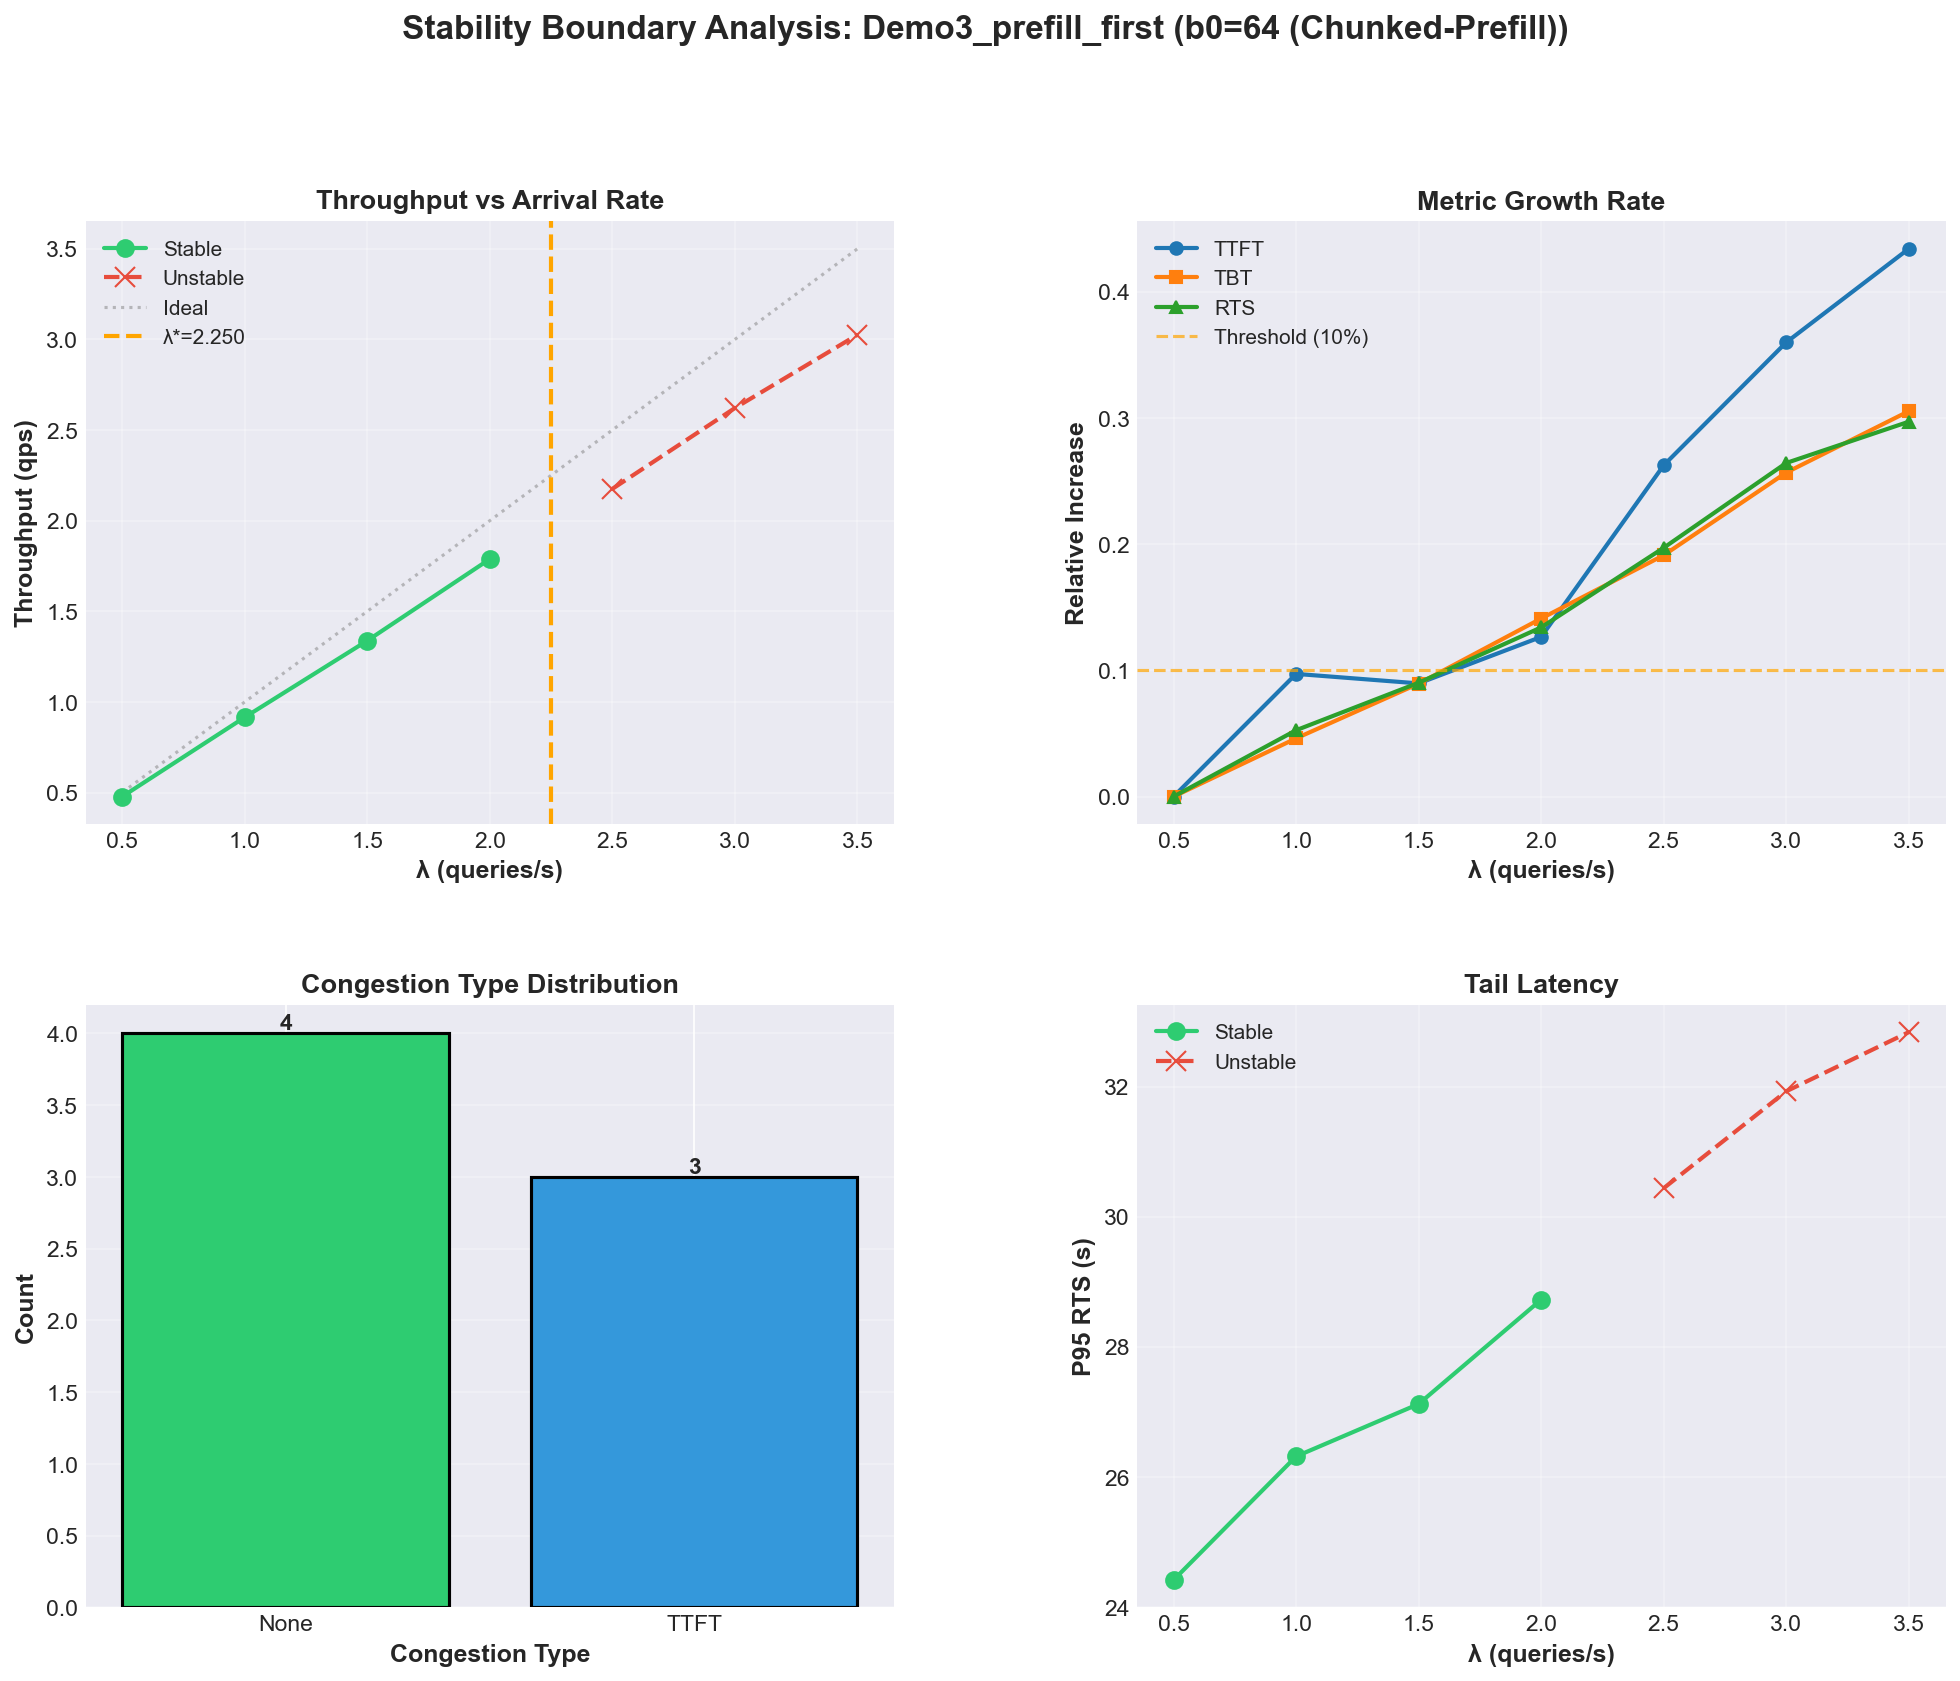

In [14]:
from IPython.display import Image, display
import glob

print("\n" + "="*80)
print("Generated Figures")
print("="*80)

demo3_figs = sorted(glob.glob('figs/Demo3*.png'))

if demo3_figs:
    for fig_path in demo3_figs:
        print(f"\n{fig_path}:")
        display(Image(filename=fig_path, width=1200))
else:
    print("\n⚠️ No figures found. Please run the experiment scripts first.")
    print("\nRequired files:")
    print("  - data/Demo3_b0_0_*_results.csv  (from demo4_demo3_b0_0.py)")
    print("  - data/Demo3_*_results.csv       (from demo4_demo3.py)")

## Summary Statistics

In [ ]:
print("\n" + "="*100)
print("Demo 3 Summary: Stability Boundaries")
print("="*100)

print(f"\n{'Scheduler':<20} | {'b0=0 λ*':<20} | {'b0=64 λ*':<20} | {'Change':<15}")
print("-"*100)

schedulers = ['Decode-First', 'Prefill-First', 'Hybrid']

for sched in schedulers:
    ls_0, cw_0 = None, None
    ls_64, cw_64 = None, None
    
    if sched in data_b0_0:
        ls_0, cw_0 = find_lambda_star(data_b0_0[sched])
    
    if sched in data_b0_64:
        ls_64, cw_64 = find_lambda_star(data_b0_64[sched])
    
    if ls_0:
        str_0 = f"{ls_0:.4f} ±{cw_0/2:.4f}" if cw_0 > 0 else f">{ls_0:.4f}"
    else:
        str_0 = "N/A"
    
    if ls_64:
        str_64 = f"{ls_64:.4f} ±{cw_64/2:.4f}" if cw_64 > 0 else f">{ls_64:.4f}"
    else:
        str_64 = "N/A"
    
    if ls_0 and ls_64:
        change_pct = (ls_64 - ls_0) / ls_0 * 100
        change_str = f"{change_pct:+.1f}%"
    else:
        change_str = "N/A"
    
    print(f"{sched:<20} | {str_0:<20} | {str_64:<20} | {change_str:<15}")

print("="*100)

print("\n" + "="*100)
print("Key Observations")
print("="*100)
print("\n1. Decode-First:")
print("   - Extremely low capacity even with b0=0")
print("   - High workload variability (LogNormal, Geometric) makes Decode-First vulnerable")
print("   - With b0=64: May completely fail due to Chunked-Prefill incompatibility")
print("\n2. Prefill-First:")
print("   - Relatively stable across b0 values")
print("   - Chunked-Prefill has minimal impact")
print("\n3. Hybrid:")
print("   - Best capacity among all policies")
print("   - May benefit slightly from Chunked-Prefill")
print("\n4. Impact of High Variability:")
print("   - LogNormal prompts: CV ≈ 3.0 (99th percentile: ~900 tokens)")
print("   - Geometric outputs: CV ≈ 1.0 (99th percentile: ~800 tokens)")
print("   - Compare to Demo 2: Fixed distributions with low variability")
print("   - Result: All schedulers have much lower capacity than Demo 2")


Demo 3 Summary: Stability Boundaries

Scheduler            | b0=0 λ*              | b0=64 λ*             | Change         
----------------------------------------------------------------------------------------------------
Decode-First         | N/A                  | N/A                  | N/A            
Prefill-First        | 1.2500 ±0.2500       | 2.2500 ±0.2500       | +80.0%         
Hybrid               | 2.7500 ±0.2500       | 8.2500 ±0.2500       | +200.0%        

Key Observations

1. Decode-First:
   - Extremely low capacity even with b0=0
   - High workload variability (LogNormal, Geometric) makes Decode-First vulnerable
   - With b0=64: May completely fail due to Chunked-Prefill incompatibility

2. Prefill-First:
   - Relatively stable across b0 values
   - Chunked-Prefill has minimal impact

3. Hybrid:
   - Best capacity among all policies
   - May benefit slightly from Chunked-Prefill

4. Impact of High Variability:
   - LogNormal prompts: CV ≈ 3.0 (99th percentile: ~9